In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 5
N_BATCH = 9
N_EPOCH = 10
LR = 0.002

In [44]:
import tensorflow as tf

# 사용할 GPU를 설정 (여기서는 GPU 0번만 사용)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 0만 TensorFlow에서 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        
        # GPU 메모리 성장 허용 설정
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # GPU가 이미 사용 중이라면 예외 발생
        print(e)
        
# TensorFlow가 실제로 GPU를 사용하는지 확인하기 위한 간단한 테스트
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU')]

In [45]:
def load_and_combine_npz_files(npz_files):
    all_images = []
    all_labels = []
    
    for npz_file in npz_files:
        data = np.load(npz_file, allow_pickle=True)
        all_images.append(data['images'])
        all_labels.append(data['numbers'])
        
    combined_images = np.concatenate(all_images, axis=0)
    combined_labels = np.concatenate(all_labels, axis=0)
    return combined_images, combined_labels

In [46]:
def add_noise_to_edges(images, noise_factor=50, edge_width=4):
    noisy_images = images.astype(np.float32)
    height, width = images.shape[1], images.shape[2]
    for i in range(images.shape[0]):
        noisy_images[i, :edge_width, :] += np.random.normal(scale=noise_factor, size=(edge_width, width))
        noisy_images[i, -edge_width:, :] += np.random.normal(scale=noise_factor, size=(edge_width, width))
        noisy_images[i, :, :edge_width] += np.random.normal(scale=noise_factor, size=(height, edge_width))
        noisy_images[i, :, -edge_width:] += np.random.normal(scale=noise_factor, size=(height, edge_width))
    return np.clip(noisy_images, 0, 255).astype(np.float32)

def add_selective_noise(images, noise_factor=60, noise_ratio=0.1):
    noisy_images = np.copy(images).astype(np.float32)
    height, width = images.shape[1], images.shape[2]
    total_pixels = height * width
    for i in range(images.shape[0]):
        noise_pixels = int(total_pixels * noise_ratio)
        noise_indices = np.random.choice(total_pixels, noise_pixels, replace=False)
        noise = np.random.normal(scale=noise_factor, size=(height, width))
        flat_img = images[i].flatten()
        np.put(flat_img, noise_indices, noise.flatten()[noise_indices])
        noisy_images[i] = flat_img.reshape(height, width)
    return np.clip(noisy_images, 0, 255).astype(np.float32)

In [47]:
num_classes = 5

def preprocess_images_and_labels(images, labels):
    images = tf.expand_dims(images, -1)

    # images = tf.image.resize(images, [96, 128], method='nearest')
    images = images / 255.0  # Normalize images to [0, 1]
    labels = tf.one_hot(labels, depth=num_classes)
    return images, labels

npz_files = [
    'dataset/make/horizon1.npz',
    'dataset/make/horizon3.npz',
    'dataset/make/hv1.npz',
    'dataset/make/hv3.npz',
    'dataset/make/origin1.npz',
    'dataset/make/origin3.npz',
    'dataset/make/vertical1.npz',
    'dataset/make/vertical3.npz',
    'dataset/npz/dataset2_horizon.npz',
    'dataset/npz/dataset2_origin.npz',
    'dataset/npz/dataset2_vertical.npz',
    'dataset/npz/dataset2_vh.npz',
]

combined_images, combined_labels = load_and_combine_npz_files(npz_files)
noisy_images = add_noise_to_edges(combined_images)
noisy_images = add_selective_noise(noisy_images)

extended_images = np.concatenate([combined_images, noisy_images], axis=0)
extended_labels = np.concatenate([combined_labels, combined_labels], axis=0)

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((extended_images, extended_labels))

shuffle_buffer_size = len(dataset)
# Preprocess and batch the dataset
# 데이터셋을 섞고 배치 처리하기
batched_dataset = dataset.shuffle(shuffle_buffer_size).map(lambda x, y: preprocess_images_and_labels(x, y)).batch(N_BATCH).prefetch(tf.data.AUTOTUNE)

# 배치의 총 수 계산하기
total_batches = len(extended_images) // N_BATCH

# 훈련 및 검증 배치의 수 계산하기
train_batches = int(0.80 * total_batches)
# val_batches = total_batches - train_batches (필요한 경우)

# 훈련 및 검증 데이터셋으로 분할하기
train_dataset = batched_dataset.take(train_batches)
val_dataset = batched_dataset.skip(train_batches)

print(len(train_dataset))

print(len(val_dataset))

1600
402


In [48]:
print(extended_images.shape)

(18016, 24, 32)


In [49]:
# print(extended_images[10000].shape) # 0
# print(extended_labels[10000])

# print(extended_images[6000].shape) # 1
# print(extended_labels[6000])

# print(extended_images[9000].shape) # 2
# print(extended_labels[9000])

# print(extended_images[13000].shape) # 3
# print(extended_labels[13000])

# print(extended_images[26485].shape) # 4
# print(extended_labels[26485])



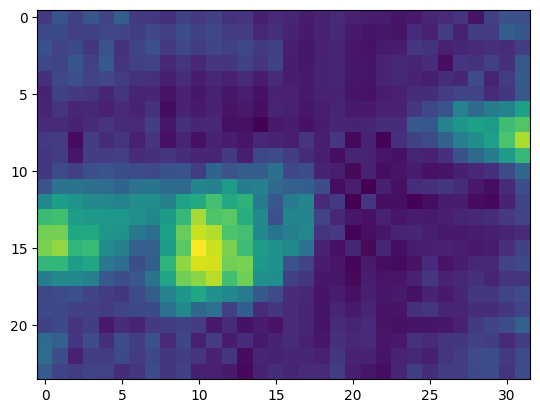

In [50]:
plt.imshow(extended_images[8000])

In [51]:
print(np.argwhere(extended_labels>3))

[[ 4645]
 [ 4674]
 [ 4675]
 ...
 [17947]
 [17948]
 [17949]]


In [52]:
# #10000, 6000, 9000, 13000, 26485
# def python_2d_array_to_c_const_2d_array(python_array, variable_name="array"):
#     # 2차원 배열의 각 행을 문자열로 변환
#     rows_str = []
#     for row in python_array:
#         row_str = ", ".join(str(element) for element in row)
#         rows_str.append(f"    {{{row_str}}}")
    
#     # 전체 배열을 문자열로 변환
#     array_str = ",\n".join(rows_str)
    
#     # C언어 형식의 문자열로 변환 (변수 이름 포함, 2차원 배열)
#     c_array_str = f"const float {variable_name}[][32] = {{\n{array_str}\n}};"
#     return c_array_str

# # 주어진 2차원 Python 배열 예시 (실제 데이터는 이 코드에서 직접 변환해야 함)
# python_array_example = extended_images[26483]

# # 변환 실행 및 결과 출력
# variable_name_example = 'four'
# c_const_code = python_2d_array_to_c_const_2d_array(python_array_example, variable_name_example)
# print(c_const_code)


Batch images shape: (9, 24, 32, 1)
Batch labels shape: (9, 5)


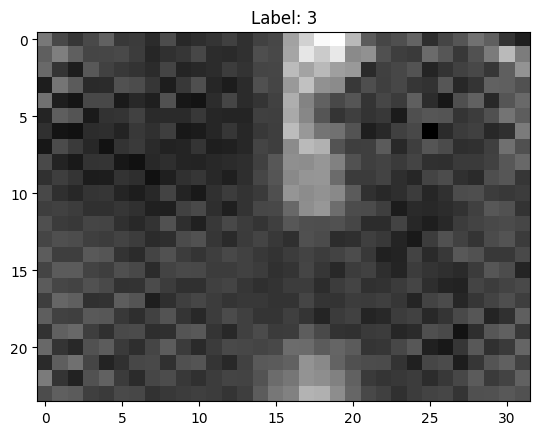

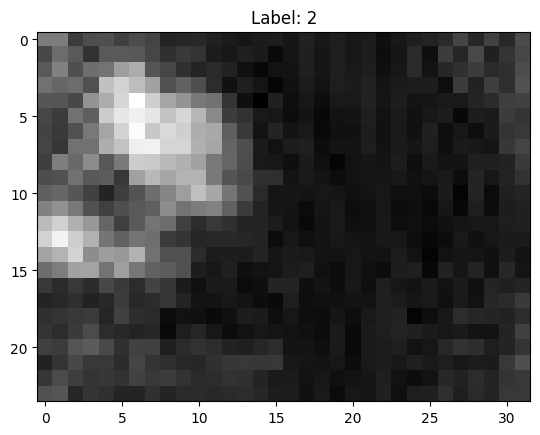

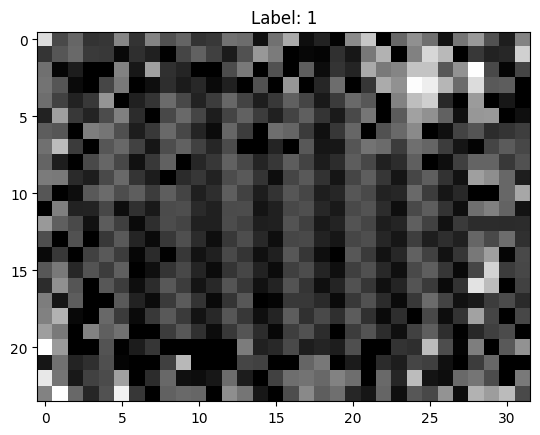

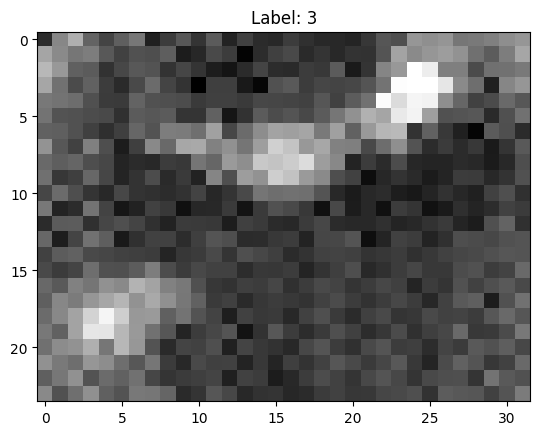

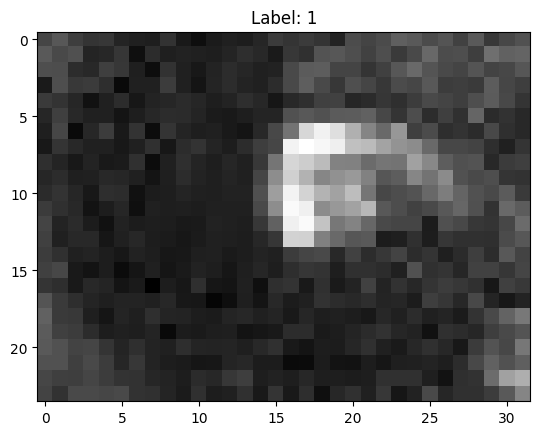

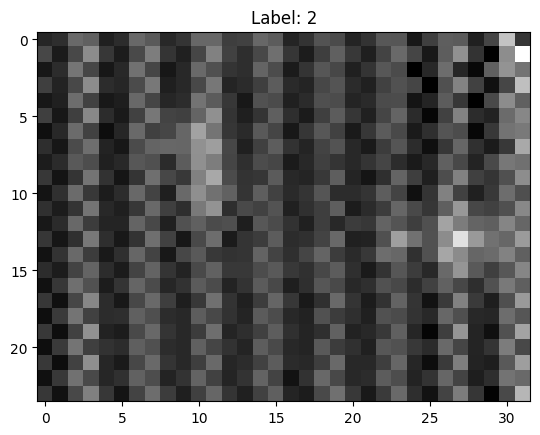

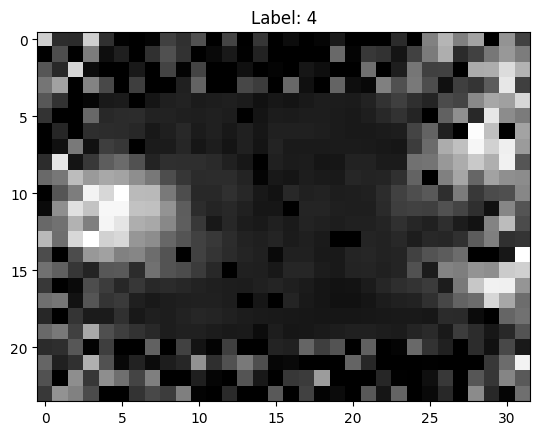

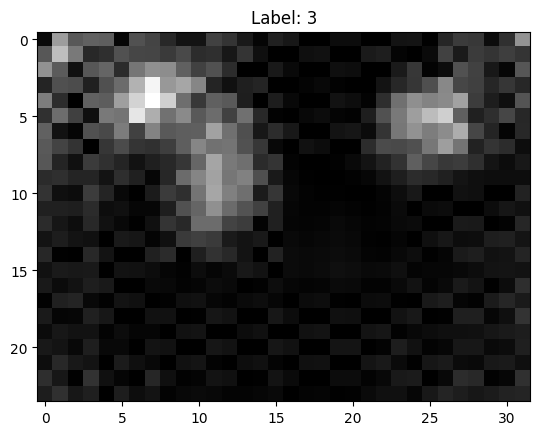

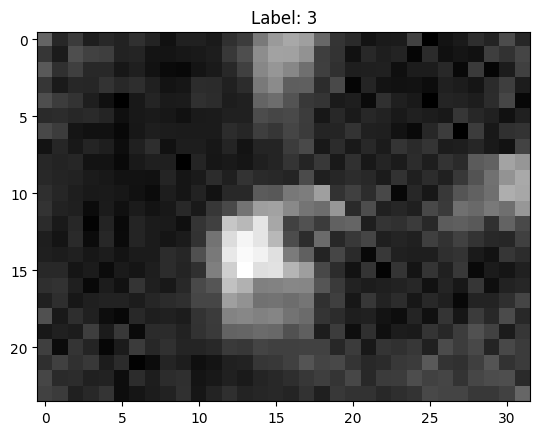

In [53]:
# Assuming `train_dataset` is your TensorFlow dataset prepared for training
for images, labels in val_dataset.take(1):  # take(1) takes the first batch
    print("Batch images shape:", images.shape)  # Print the shape of the batch of images
    print("Batch labels shape:", labels.shape)  # Print the shape of the batch of labels
    
    # TensorFlow datasets typically deal with batches directly,
    # so we iterate through the batch like this:
    for img, label in zip(images, labels):
        # Since the images were normalized to [0, 1], we don't need to scale them back for visualization
        plt.imshow(img.numpy(), cmap='gray')
        plt.title(f"Label: {np.argmax(label.numpy())}")
        plt.show()
    break


In [54]:
class DepthwiseSeparableConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same' if padding else 'valid', depth_multiplier=1, strides=stride)
        self.pointwise = layers.Conv2D(out_channels, kernel_size=1, strides=1)

    def call(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DepthwiseConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConv, self).__init__()
        self.depthwise = DepthwiseSeparableConv(in_channels, out_channels, kernel_size, stride, padding)
        self.batch_norm = layers.BatchNormalization()
        self.silu = layers.Activation('silu')

    def call(self, x):
        out = self.depthwise(x)
        out = self.batch_norm(out)
        out = self.silu(out)
        return out

In [55]:
class Conv(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=2, padding='SAME'):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=stride, padding=padding, kernel_initializer=tf.keras.initializers.HeNormal())
        self.batch_norm = layers.BatchNormalization()
        self.relu = layers.Activation('relu')

    def call(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        return self.relu(x)

In [56]:
class Bottleneck(layers.Layer):
    def __init__(self, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv_0 = Conv(out_channels, kernel_size=1, stride=stride, padding='same')
        self.conv_1 = Conv(out_channels, kernel_size=3, stride=stride, padding='same')

    def call(self, x):
        identity = x
        out = self.conv_0(x)
        out = self.conv_1(out)
        out += identity
        return out

In [57]:
class ChannelAttention(layers.Layer):
    def __init__(self, pool_types=['avg', 'max'], kernel_size=3):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        pooled_features = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pooled = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
            elif pool_type == 'max':
                pooled = tf.reduce_max(x, axis=[1, 2], keepdims=True)
            pooled_features.append(pooled)
        
        concat = tf.concat(pooled_features, axis=-1)
        attention = self.conv(concat)
        attention = self.sigmoid(attention)
        return x * attention

In [58]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal())
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        x = tf.concat([avg_out, max_out], axis=-1)
        x = self.conv(x)
        return self.sigmoid(x)


In [59]:
class CBAM(layers.Layer):
    def __init__(self, pool_types=['avg', 'max'], kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(pool_types, kernel_size)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x) * x
        return x

In [68]:
class SPPF(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, padding='SAME'):
        super(SPPF, self).__init__()
        self.conv1 = Conv(out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = Conv(out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool1 = layers.MaxPooling2D(pool_size=3, strides=1, padding='SAME')
        self.maxpool2 = layers.MaxPooling2D(pool_size=3, strides=1, padding='SAME')
        # self.maxpool3 = layers.MaxPooling2D(pool_size=5, strides=1, padding='SAME')
        self.conv3 = Conv(out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    def call(self, inputs):
        x = self.conv1(inputs)
    
        pool1 = self.maxpool1(x)
        pool2 = self.maxpool2(pool1)
        # pool3 = self.maxpool3(x)

        # concatenated = tf.concat([x, pool1, pool2], axis=-1)
        pool = tf.concat([pool1, pool2], axis=-1)
        pool = self.conv2(pool)
        concatenated = x * pool

        out = self.conv3(concatenated)
        return out

In [69]:
# MultiStageFeatureExtractionLayer
class MSFELayer(layers.Layer):
    def __init__(self, sperate_input_channel, out_channel):
        super(MSFELayer, self).__init__()
        self.sppf = SPPF(sperate_input_channel)
        # self.cbam = CBAM()
        # self.bottleneck = Bottleneck(sperate_input_channel)
        # self.conv1 = Conv(sperate_input_channel, kernel_size=1, stride=1, padding='SAME')
        self.conv_out = Conv(out_channel, kernel_size=3, stride=1, padding='SAME')

    def call(self, x):
        # sppf, cbam, conv = tf.split(x, num_or_size_splits=3, axis=-1)
        sppf = self.sppf(x)
        # cbam = self.cbam(cbam)
        # bottle = self.bottleneck(x)
        # conv = self.conv1(conv)
        # out = tf.concat([sppf, cbam, conv], axis = -1)
        out = self.conv_out(sppf)
        return out


In [70]:
def BackBone():
    input_layer = tf.keras.Input(shape=(24, 32, 1))
    x = Conv(9, 6, 2)(input_layer)
    x = MSFELayer(9, 12)(x)

    x = Conv(12, 3, 2)(x)
    x = MSFELayer(12, 15)(x)

    x = Conv(18, 3, 2)(x)
    x = MSFELayer(18, 21)(x)

    x = Conv(24, 3, 2)(x)
    x = MSFELayer(24, 27)(x)

    x = layers.GlobalAveragePooling2D()(x)
    output_layer = layers.Dense(5, activation='softmax')(x)

    # 모델 인스턴스 생성
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model



In [71]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

model = BackBone()
# model = backbone()

initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

TypeError: __init__() missing 1 required positional argument: 'out_channels'

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint('Classification/Model/model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
model.build(input_shape=(1, 24, 32, 1))

In [ ]:
model.summary()

In [ ]:
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCH,
    verbose=1,  
    callbacks=[checkpoint]
    # callbacks=[checkpoint, lr_reducer]
)


# 기존
# Epoch 13: val_accuracy improved from 0.96870 to 0.97386, saving model to Classification/Model/model.h5
# 1204/1204 [==============================] - 53s 44ms/step - loss: 0.1284 - accuracy: 0.9574 - precision_1: 0.9591 - recall_1: 0.9559 - val_loss: 0.0773 - val_accuracy: 0.9739 - val_precision_1: 0.9745 - val_recall_1: 0.9728


# Only BottleNeck
# Epoch 10: val_accuracy improved from 0.93114 to 0.94718, saving model to Classification/Model/model.h5
# 1600/1600 [==============================] - 40s 25ms/step - loss: 0.2397 - accuracy: 0.9144 - precision: 0.9189 - recall: 0.9100 - val_loss: 0.1552 - val_accuracy: 0.9472 - val_precision: 0.9491 - val_recall: 0.9439

# Only SPPF


In [ ]:
q!

In [ ]:
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCH,
    verbose=1,  
    callbacks=[checkpoint]
    # callbacks=[checkpoint, lr_reducer]
)



In [ ]:
val_acc = model.evaluate(val_dataset) 
print(f"Validation Accuracy: {val_acc[1] * 100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

for images, labels in val_dataset.take(1):  # Take a single batch from the validation dataset
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    
    for img, label, predicted in zip(images, labels, predicted_classes):
        plt.imshow(img.numpy().squeeze(), cmap='gray')  # Assuming grayscale images
        plt.title(f"Actual: {np.argmax(label)}, Predicted: {predicted.numpy()}")
        plt.show()



In [ ]:
from tensorflow import keras
custom_objects = {
    'Conv': Conv,
    'DepthwiseSeparableConv': DepthwiseSeparableConv,
    'DepthwiseConv': DepthwiseConv,
    'Bottleneck': Bottleneck,
    'CSPDenseLayer': CSPDenseLayer,
    'CBAM': CBAM,
    'SPPF': SPPF,
}

model = keras.models.load_model('Classification/Model/model.h5', custom_objects=custom_objects, compile=False)

export_path = 'Classification/Model/model.pb'
model.save(export_path, save_format="tf")

In [ ]:
import tensorflow as tf

saved_model_dir = 'Classification/Model/model.pb'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open('Classification/Model/model.tflite', 'wb').write(tflite_model)

In [ ]:
import numpy as np
import tensorflow as tf

# TFLite 모델 파일 경로
tflite_model_file = 'Classification/Model/model_conv.tflite'

# TFLite 모델을 로드합니다.
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

# 가중치의 총합을 계산합니다.
total_weights = 0
for tensor_details in interpreter.get_tensor_details():
    # 각 tensor의 shape에서 요소의 총수(가중치 수)를 계산합니다.
    total_weights += np.prod(tensor_details['shape'])

print(f'Total weights in the model: {total_weights}')
